In [1]:
import sys
sys.path.insert(0, '../')
from functions import *

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
# Random Seed for dataset generation
sampling_seed = 15
torch.manual_seed(sampling_seed)

In [ ]:
# Training data
data = pd.read_table('TrainingData.txt', delimiter=',', dtype='float')
t_len = data.shape[0]

#tf0 = np.array(data.tf0)
#ts0 = np.array(data.ts0)

# Testing data
test = pd.read_table('TestingData.txt', dtype='float')
test_len = test.shape[0]

t_test = torch.tensor(np.linspace(t_len-test_len,t_len,num=test.shape[0])).reshape(-1,1)
#t_test = torch.tensor(np.linspace(0,test_len,num=test.shape[0])).reshape(-1,1)

tf0, ts0 = np.array([]), np.array([])
i = 0
while 35*i < data.tf0.shape[0]:
    j = 0
    while j < 5**i:
        tf0 = np.concatenate([tf0, np.array(data.tf0[35*i:35*(i+1)])])
        ts0 = np.concatenate([ts0, np.array(data.ts0[35*i:35*(i+1)])])
        j += 1
    i += 1

sort = False
if sort == True:
    # Sorting
    index_tf0_test = np.argsort(tf0[t_len-test_len:t_len])
    index_ts0_test = np.argsort(ts0[t_len-test_len:t_len])

#print(ts0[t_len-test_len:t_len])
#print(index_ts0_test)

    index_tf0 = np.argsort(tf0)
    tf0 = tf0[index_tf0]
    index_ts0 = np.argsort(ts0)
    ts0 = ts0[index_ts0]

t = torch.tensor(np.linspace(0,t_len,num=tf0.shape[0])).reshape(-1,1)
#t = torch.tensor(np.linspace(0,test_len,num=test.shape[0])).reshape(-1,1)
tf0 = torch.tensor(tf0).reshape(-1,1)
ts0 = torch.tensor(ts0).reshape(-1,1)

data_mean = np.array([t.mean(), tf0.mean(), ts0.mean()])
data_std = np.array([t.std(), tf0.std(), ts0.std()])

plt.figure()
plt.scatter((t-data_mean[0])/data_std[0],(tf0-data_mean[1])/data_std[1])
plt.scatter((t-data_mean[0])/data_std[0],(ts0-data_mean[1])/data_std[1])
plt.legend(['$T_f\,(0,t)$','$T_s\,(0,t)$'])
plt.show()

In [ ]:
# Cut
cut = 0
t_cut = t[cut:]
tf0_cut = tf0[cut:]
ts0_cut = ts0[cut:]

# Normalization of data

t_cut = (t_cut-data_mean[0])/data_std[0]
tf0_cut = (tf0_cut-data_mean[1])/data_std[1]
ts0_cut = (ts0_cut-data_mean[2])/data_std[2]

#plt.figure()
#plt.scatter(t_cut,tf0_cut)
#plt.scatter(t_cut,ts0_cut)
#plt.legend(['$T_f\,(0,t)$','$T_s\,(0,t)$'])
#plt.show()

perc = 0

validation_size = int(perc*t_cut.shape[0]/100)
training_size = t_cut.shape[0] - validation_size
t_train = t_cut[:training_size]
tf0_train = tf0_cut[:training_size]
ts0_train = ts0_cut[:training_size]

t_val = t_cut[training_size:]
tf0_val = tf0_cut[training_size:]
ts0_val = ts0_cut[training_size:]

In [ ]:
batch_size = t_cut.shape[0]
retrain = 128
n_epochs = 500

training_f = DataLoader(torch.utils.data.TensorDataset(t_train, tf0_train), batch_size=batch_size, shuffle=True)
training_s = DataLoader(torch.utils.data.TensorDataset(t_train, ts0_train), batch_size=batch_size, shuffle=True)

my_network_f = NeuralNet_Seq(input_dimension=t.shape[1], output_dimension=tf0.shape[1], n_hidden_layers=4, neurons=20)
my_network_s = NeuralNet_Seq(input_dimension=t.shape[1], output_dimension=ts0.shape[1], n_hidden_layers=4, neurons=20)

init_xavier(my_network_f, retrain + np.random.randint(-retrain,retrain))
init_xavier(my_network_s, retrain + np.random.randint(-retrain,retrain))

optimizer_f = optim.LBFGS(my_network_f.parameters(), lr=0.5, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
optimizer_s = optim.LBFGS(my_network_s.parameters(), lr=0.5, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)

if perc == 0:
    history_f = fit(my_network_f, training_f, n_epochs, optimizer_f, p=2, reg_param = 0.0, verbose=False)
    print('k')
    history_s = fit(my_network_s, training_s, n_epochs, optimizer_s, p=2, reg_param = 0.0, verbose=False)
else:
    history_f = fit_k(my_network_f, training_f, t_val.float(), tf0_val, n_epochs, optimizer_f, p=2, reg_param = 0.01, verbose=False)
    history_s = fit_k(my_network_s, training_s, t_val.float(), ts0_val, n_epochs, optimizer_s, p=2, reg_param = 0.01, verbose=False)

In [ ]:
plt.figure()
plt.grid(True, which="both", ls=":")
if perc == 0:
    plt.plot(np.arange(1,n_epochs+1), history_f, label="Training Loss - Fluid")
    plt.plot(np.arange(1,n_epochs+1), history_s, label="Training Loss - Solid")
else:
    plt.plot(np.arange(1,n_epochs+1), history_f[0], label="Training Loss - Fluid")
    plt.plot(np.arange(1,n_epochs+1), history_s[0], label="Training Loss - Solid")
    plt.plot(np.arange(1,n_epochs+1), history_f[1], label="Validation Loss - Fluid")
    plt.plot(np.arange(1,n_epochs+1), history_s[1], label="Validation Loss - Solid")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("epochs")
plt.legend()

In [ ]:
# Prediction
tf0_test_pred = my_network_f((t_test.float()-t_test.mean())/t_test.std()).reshape(-1,).detach()
ts0_test_pred = my_network_s((t_test.float()-t_test.mean())/t_test.std()).reshape(-1,).detach()

#data_mean_cut = np.array([t[45:].mean(), tf0[45:].mean(), ts0[45:].mean()])
#data_std_cut = np.array([t[45:].std(), tf0[45:].std(), ts0[45:].std()])

tf0_test_pred = tf0_test_pred*data_std[1] + data_mean[1]
ts0_test_pred = ts0_test_pred*data_std[2] + data_mean[2]

plt.figure()
plt.scatter(t_test, tf0_test_pred)
plt.scatter(t_test, ts0_test_pred)
plt.legend(['$T_f\,(0,t)$ prediction','$T_s\,(0,t)$ prediction'])
plt.show()

In [ ]:
if sort == True:
    tf0_test_pred = tf0_test_pred[np.argsort(index_tf0_test)]
    ts0_test_pred = ts0_test_pred[np.argsort(index_ts0_test)]

# Export to text file
df = pd.DataFrame({'t': np.array(test.t), 'tf0': np.array(tf0_test_pred), 'ts0': np.array(ts0_test_pred)})
df.to_csv('Task3_.txt', header = True, index = None)

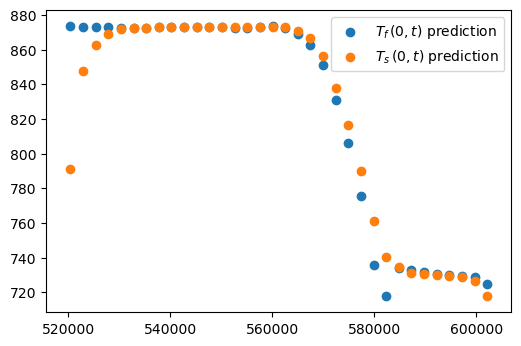

In [4]:
# Verification
import sys
sys.path.insert(0, '../')
from functions import *

data = pd.read_table('TrainingData.txt', delimiter=',', dtype='float')
pred = pd.read_table('Task3_.txt', delimiter=',', dtype='float')

plt.figure()
plt.scatter(pred.t, pred.tf0)
plt.scatter(pred.t, pred.ts0)
plt.legend(['$T_f\,(0,t)$ prediction','$T_s\,(0,t)$ prediction'])
plt.show()

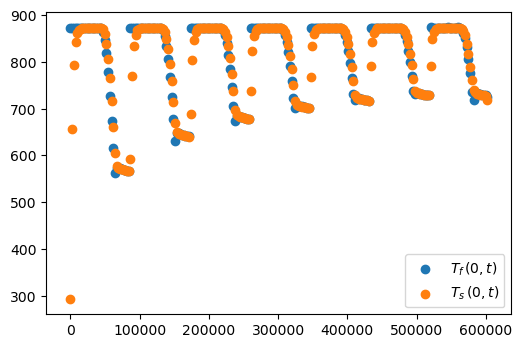

In [5]:
plt.figure()
plt.scatter(data.t.append(pred.t), data.tf0.append(pred.tf0))
plt.scatter(data.t.append(pred.t), data.ts0.append(pred.ts0))
plt.legend(['$T_f\,(0,t)$','$T_s\,(0,t)$'])
plt.show()

t = torch.tensor(np.linspace(0,1,num=int(tf0.shape[0]/6))).reshape(-1,1)

batch_size = t.shape[0]
retrain = 128
n_epochs = 500

my_network_f = NeuralNet_Seq(input_dimension=t.shape[1], output_dimension=tf0.shape[1], n_hidden_layers=4, neurons=20)
my_network_s = NeuralNet_Seq(input_dimension=t.shape[1], output_dimension=ts0.shape[1], n_hidden_layers=4, neurons=20)

init_xavier(my_network_f, retrain + np.random.randint(-retrain,retrain))
init_xavier(my_network_s, retrain + np.random.randint(-retrain,retrain))

optimizer_f = optim.LBFGS(my_network_f.parameters(), lr=0.1, max_iter=20, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
optimizer_s = optim.LBFGS(my_network_s.parameters(), lr=0.1, max_iter=20, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)

i = 0
while i < tf0.shape[0]:
    tf0_cut = tf0[i:i+35]
    ts0_cut = ts0[i:i+35]

    data_mean = np.array([t.mean(), tf0_cut.mean(), ts0_cut.mean()])
    data_std = np.array([t.std(), tf0_cut.std(), ts0_cut.std()])

    t = (t-data_mean[0])/data_std[0]
    tf0_cut = (tf0_cut-data_mean[1])/data_std[1]
    ts0_cut = (ts0_cut-data_mean[2])/data_std[2]

    perc = 0

    validation_size = int(perc*t.shape[0]/100)
    training_size = t.shape[0] - validation_size
    t_train = t[:training_size]
    tf0_train = tf0_cut[:training_size]
    ts0_train = ts0_cut[:training_size]

    t_val = t[training_size:]
    tf0_val = tf0_cut[training_size:]
    ts0_val = ts0_cut[training_size:]

    training_f = DataLoader(torch.utils.data.TensorDataset(t_train, tf0_train), batch_size=batch_size, shuffle=True)
    training_s = DataLoader(torch.utils.data.TensorDataset(t_train, ts0_train), batch_size=batch_size, shuffle=True)

    if perc == 0:
        history_f = fit(my_network_f, training_f, n_epochs, optimizer_f, p=2, reg_param = 0.0, verbose=False)
        history_s = fit(my_network_s, training_s, n_epochs, optimizer_s, p=2, reg_param = 0.0, verbose=False)
    else:
        history_f = fit_k(my_network_f, training_f, t_val.float(), tf0_val, n_epochs, optimizer_f, p=2, reg_param = 0.01, verbose=False)
        history_s = fit_k(my_network_s, training_s, t_val.float(), ts0_val, n_epochs, optimizer_s, p=2, reg_param = 0.01, verbose=False)
    
    i += 35

n_samples = t.shape[0]
batch_size = n_samples
retrain = 128
n_epochs = 1500
tt = 0
my_network_f = NeuralNet_Seq(input_dimension=t.shape[1], output_dimension=tf0.shape[1], n_hidden_layers=4, neurons=20)
my_network_s = NeuralNet_Seq(input_dimension=t.shape[1], output_dimension=ts0.shape[1], n_hidden_layers=4, neurons=20)
init_xavier(my_network_f, retrain)
init_xavier(my_network_s, retrain)
optimizer_f = optim.LBFGS(my_network_f.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
optimizer_s = optim.LBFGS(my_network_s.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
while tt < t_len:
    training_f = DataLoader(torch.utils.data.TensorDataset(t, tf0[tt:tt+test_len]), batch_size=batch_size, shuffle=True)
    training_s = DataLoader(torch.utils.data.TensorDataset(t, ts0[tt:tt+test_len]), batch_size=batch_size, shuffle=True)
    history_f = fit(my_network_f, training_f, n_epochs, optimizer_f, p=2, verbose=False)
    history_s = fit(my_network_s, training_s, n_epochs, optimizer_s, p=2, verbose=False)
    tt += test_len
    print(tt)